In [1]:
# Required Libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
calls = pd.read_csv("C:/Users/gurno/Downloads/callsf0d4f5a.csv")
customers = pd.read_csv("C:/Users/gurno/Downloads/customers2afd6ea.csv")
reasons = pd.read_csv("C:/Users/gurno/Downloads/reason.csv")
sentiments = pd.read_csv("C:/Users/gurno/Downloads/sentiment_statisticscc1e57a.csv")

# Parse datetime columns in calls.csv
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])

# Merge all datasets on call_id
data = calls.merge(reasons, on='call_id').merge(sentiments, on=['call_id', 'agent_id']).merge(customers, on='customer_id')

# Export the merged DataFrame to a new CSV file
# data.to_csv("C:/Users/gurno/Downloads/merged_output.csv", index=False)

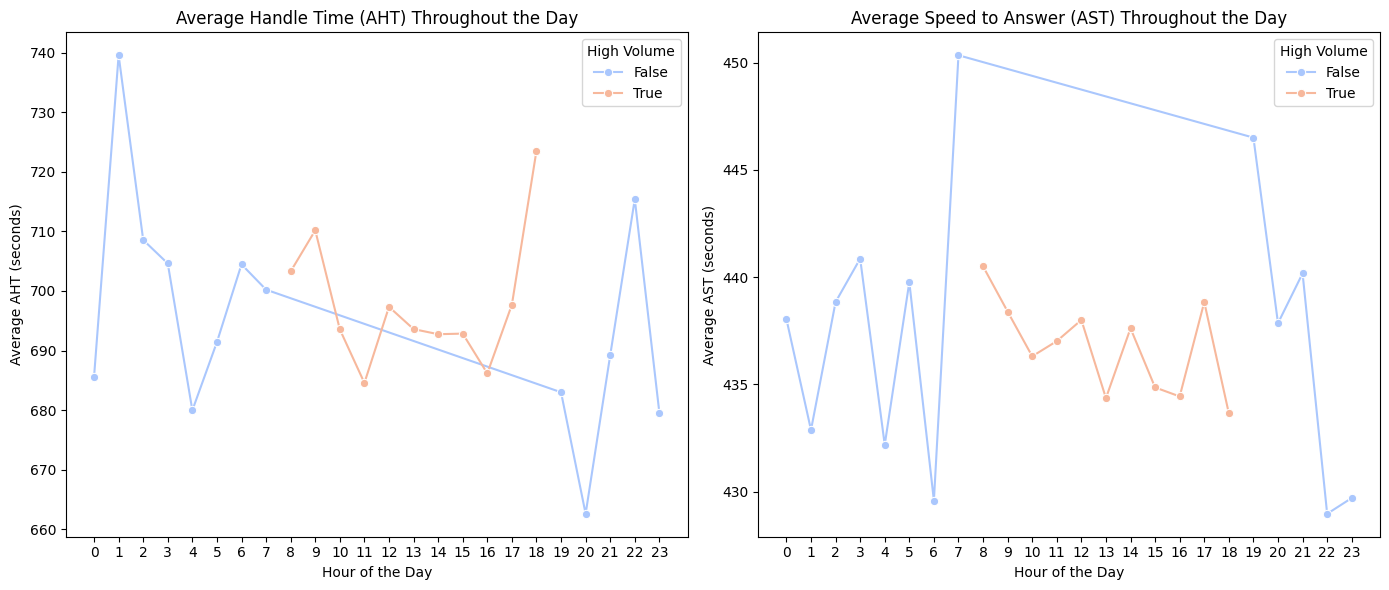

In [2]:

# Convert datetime columns to datetime type if not already done
data['call_start_datetime'] = pd.to_datetime(data['call_start_datetime'])
data['agent_assigned_datetime'] = pd.to_datetime(data['agent_assigned_datetime'])
data['call_end_datetime'] = pd.to_datetime(data['call_end_datetime'])

# Calculate AHT and AST
data['handle_time'] = (data['call_end_datetime'] - data['agent_assigned_datetime']).dt.total_seconds()  # AHT
data['speed_to_answer'] = (data['agent_assigned_datetime'] - data['call_start_datetime']).dt.total_seconds()  # AST

# Extract the hour from the call start time for volume analysis
data['call_hour'] = data['call_start_datetime'].dt.hour

# Determine call volume by hour
call_volume = data.groupby('call_hour').size().reset_index(name='call_count')

# Calculate the average call count to determine high-volume hours
average_call_volume = call_volume['call_count'].mean()

# Flag high-volume hours
call_volume['is_high_volume'] = call_volume['call_count'] > average_call_volume
data = data.merge(call_volume[['call_hour', 'is_high_volume']], on='call_hour')

# Calculate AHT and AST for each hour
hourly_metrics = data.groupby(['call_hour', 'is_high_volume']).agg({
    'handle_time': 'mean',
    'speed_to_answer': 'mean'
}).reset_index()

# Rename columns for clarity
hourly_metrics.columns = ['Call Hour', 'High Volume', 'Average AHT (seconds)', 'Average AST (seconds)']

# Plotting the AHT and AST throughout the day
plt.figure(figsize=(14, 6))

# AHT Plot
plt.subplot(1, 2, 1)
sns.lineplot(data=hourly_metrics, x='Call Hour', y='Average AHT (seconds)', hue='High Volume', palette='coolwarm', marker='o')
plt.title('Average Handle Time (AHT) Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average AHT (seconds)')
plt.xticks(range(0, 24))

# AST Plot
plt.subplot(1, 2, 2)
sns.lineplot(data=hourly_metrics, x='Call Hour', y='Average AST (seconds)', hue='High Volume', palette='coolwarm', marker='o')
plt.title('Average Speed to Answer (AST) Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average AST (seconds)')
plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

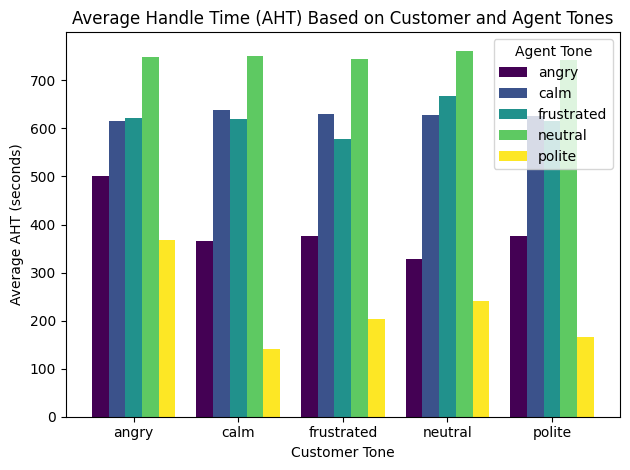

In [3]:
# Calculate average AHT based on both customer tone and agent tone
tone_aht = data.groupby(['customer_tone', 'agent_tone']).agg({'handle_time': 'mean'}).reset_index()

# Rename columns for clarity
tone_aht.columns = ['Customer Tone', 'Agent Tone', 'Average AHT (seconds)']

# Pivot the DataFrame for plotting
tone_aht_pivot = tone_aht.pivot(index='Customer Tone', columns='Agent Tone', values='Average AHT (seconds)')

# Plotting the AHT based on customer tone and agent tone
plt.figure(figsize=(10, 6))
tone_aht_pivot.plot(kind='bar', stacked=False, colormap='viridis', width=0.8)

plt.title('Average Handle Time (AHT) Based on Customer and Agent Tones')
plt.xlabel('Customer Tone')
plt.ylabel('Average AHT (seconds)')
plt.xticks(rotation=0)  # Rotate x labels to be horizontal
plt.legend(title='Agent Tone')
plt.tight_layout()
plt.show()


Most Frequent Call Reason: IRROPS, AHT: 785.12 seconds
Least Frequent Call Reason: UNACCOMPANIED MINOR, AHT: 519.23 seconds
Percentage Difference: 51.21%


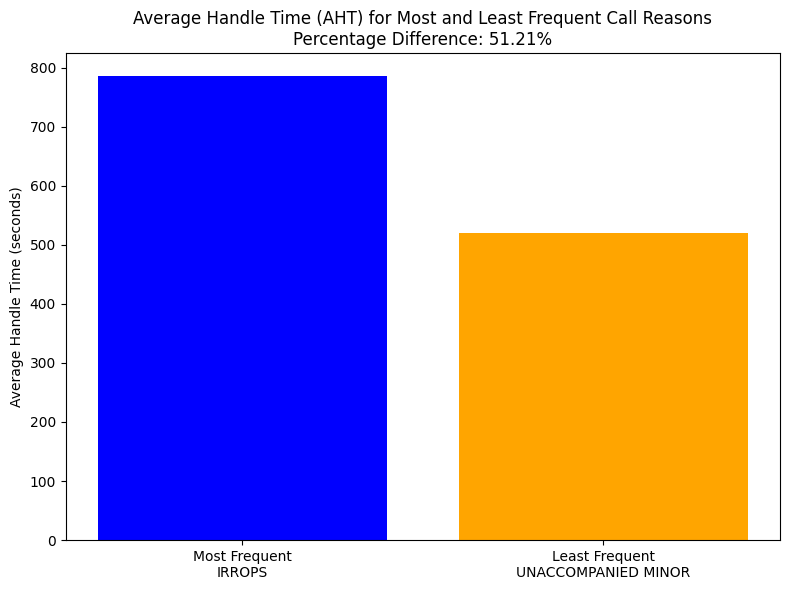

In [4]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your merged DataFrame and 'handle_time' is already calculated
# Calculate AHT by primary call reason
aht_by_reason = data.groupby('primary_call_reason')['handle_time'].mean().reset_index()

# Count the frequency of each call reason
reason_counts = data['primary_call_reason'].value_counts()

# Identify most frequent and least frequent call reasons
most_frequent_reason = reason_counts.idxmax()
least_frequent_reason = reason_counts.idxmin()

# Calculate the AHT for the most frequent and least frequent call reasons
most_frequent_aht = aht_by_reason[aht_by_reason['primary_call_reason'] == most_frequent_reason]['handle_time'].values[0]
least_frequent_aht = aht_by_reason[aht_by_reason['primary_call_reason'] == least_frequent_reason]['handle_time'].values[0]

# Calculate the percentage difference in AHT
percentage_diff = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100

# Display the AHT values and percentage difference
print(f"Most Frequent Call Reason: {most_frequent_reason}, AHT: {most_frequent_aht:.2f} seconds")
print(f"Least Frequent Call Reason: {least_frequent_reason}, AHT: {least_frequent_aht:.2f} seconds")
print(f"Percentage Difference: {percentage_diff:.2f}%")

# Plotting the AHT for most and least frequent call reasons
plt.figure(figsize=(8, 6))
plt.bar(['Most Frequent\n' + most_frequent_reason, 'Least Frequent\n' + least_frequent_reason],
        [most_frequent_aht, least_frequent_aht], color=['blue', 'orange'])

# Adding labels and title
plt.title(f"Average Handle Time (AHT) for Most and Least Frequent Call Reasons\n"
          f"Percentage Difference: {percentage_diff:.2f}%")
plt.ylabel("Average Handle Time (seconds)")
plt.tight_layout()
plt.show()


C:\Users\gurno\AppData\Local\Temp\ipykernel_12740\1822582347.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = aht_by_tone.pivot('customer_tone', 'agent_tone', 'handle_time')


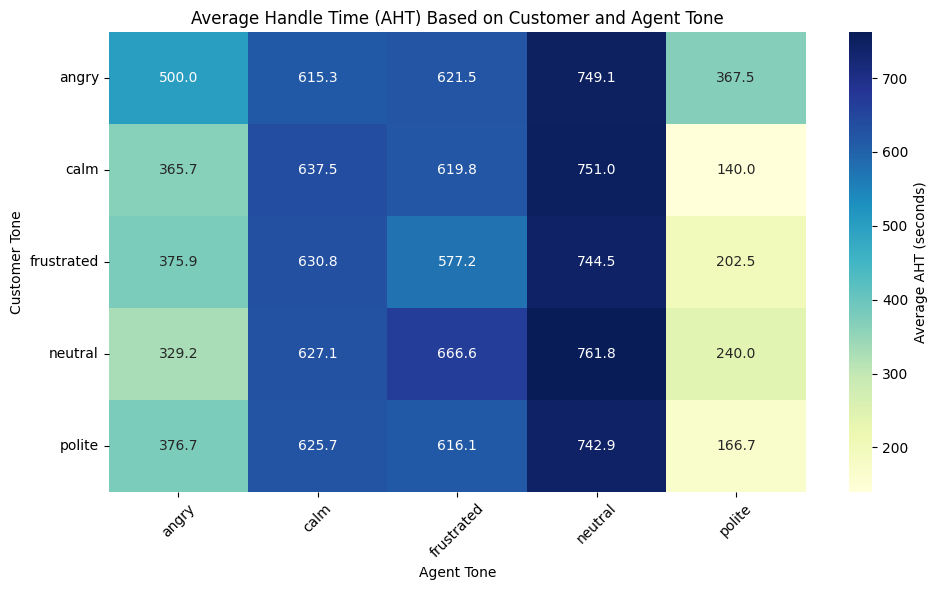

In [5]:
# Calculate AHT if not already done
data['handle_time'] = (data['call_end_datetime'] - data['agent_assigned_datetime']).dt.total_seconds()  # AHT

# Group by customer tone and agent tone, calculating the mean AHT
aht_by_tone = data.groupby(['customer_tone', 'agent_tone']).agg({'handle_time': 'mean'}).reset_index()

# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = aht_by_tone.pivot('customer_tone', 'agent_tone', 'handle_time')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='YlGnBu', cbar_kws={'label': 'Average AHT (seconds)'})
plt.title('Average Handle Time (AHT) Based on Customer and Agent Tone')
plt.xlabel('Agent Tone')
plt.ylabel('Customer Tone')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


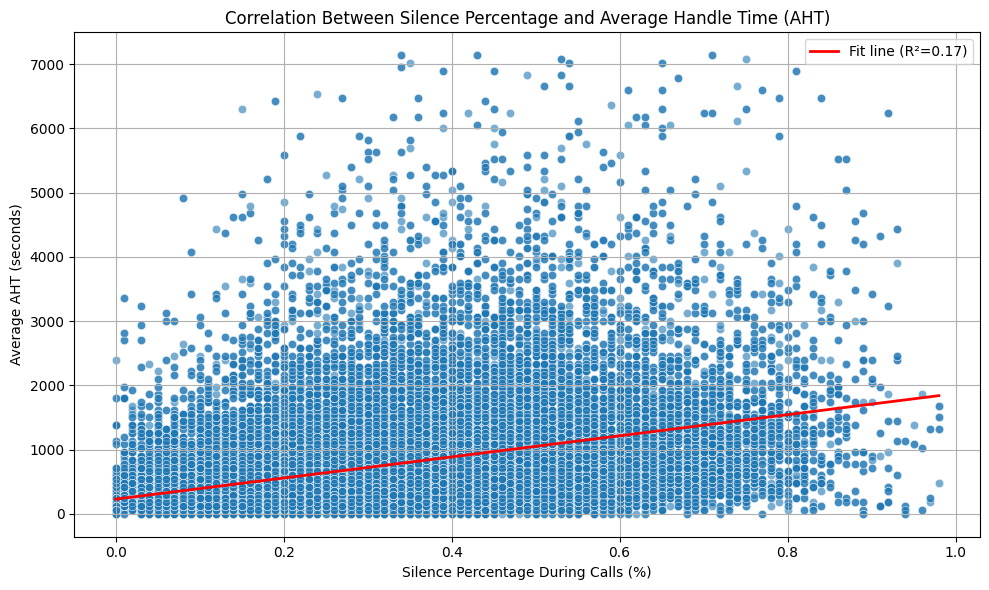

In [6]:
from scipy.stats import linregress
# Scatter Plot of Silence Percentage vs AHT
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='silence_percent_average', y='handle_time', alpha=0.6)

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = linregress(data['silence_percent_average'], data['handle_time'])
x = np.linspace(data['silence_percent_average'].min(), data['silence_percent_average'].max(), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', linewidth=2, label=f'Fit line (R²={r_value**2:.2f})')

# Titles and labels
plt.title('Correlation Between Silence Percentage and Average Handle Time (AHT)')
plt.xlabel('Silence Percentage During Calls (%)')
plt.ylabel('Average AHT (seconds)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [9]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Assuming 'data' is your merged DataFrame

# 1. Preprocessing for AHT and Sentiment
# Calculate AHT if not done already
data['handle_time'] = (data['call_end_datetime'] - data['agent_assigned_datetime']).dt.total_seconds()

# Convert sentiment and AHT into usable features
X = data[['handle_time', 'average_sentiment', 'silence_percent_average']]

# 2. Process Call Transcripts using TF-IDF
# Remove "Agent:" and "Customer:" prefixes from transcripts for cleaner text
def clean_transcript(transcript):
    transcript = transcript.replace("Agent:", "").replace("Customer:", "")
    return transcript

data['cleaned_transcript'] = data['call_transcript'].apply(clean_transcript)

# TF-IDF Vectorizer for text features
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
transcript_features = tfidf.fit_transform(data['cleaned_transcript'])

# Combine transcript features with numerical features (AHT, sentiment, etc.)
X_transcript = pd.DataFrame(transcript_features.toarray(), columns=tfidf.get_feature_names_out())
X = pd.concat([X.reset_index(drop=True), X_transcript.reset_index(drop=True)], axis=1)

# 3. Target Variable (Primary Call Reason)
y = data['primary_call_reason']

# 4. Train/Test Split
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, data.index, test_size=0.3, random_state=42)

# 5. Build Classifier (Random Forest in this case)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. Make Predictions on Test Set
y_pred = clf.predict(X_test)

# 7. Create DataFrame with actual, predicted primary call reason, and call_id
results = data.loc[test_idx, ['call_id', 'primary_call_reason']].copy()
results['predicted_primary_call_reason'] = y_pred

# 8. Save the results to a CSV file
results.to_csv('call_predictions.csv', index=False)

# 9. Evaluate the model with Precision, Recall, F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(y_test))

# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Optionally, Print Precision, Recall, F1-Score for each class
for idx, label in enumerate(np.unique(y_test)):
    print(f"Class: {label}")
    print(f"  Precision: {precision[idx]:.2f}")
    print(f"  Recall: {recall[idx]:.2f}")
    print(f"  F1-Score: {f1_score[idx]:.2f}")
    print("-" * 30)


c:\Users\gurno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gurno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:

                       precision    recall  f1-score   support

              BAGGAGE       0.06      0.00      0.00       855
              BOOKING       0.00      0.00      0.00       809
             CHECK IN       0.00      0.00      0.00       583
             CHECKOUT       0.00      0.00      0.00       559
       COMMUNICATIONS       0.00      0.00      0.00      1146
      DIGITAL SUPPORT       0.00      0.00      0.00       345
           DISABILITY       0.00      0.00      0.00       119
                  ETC       0.00      0.00      0.00       294
               IRROPS       0.23      0.76      0.36      4045
         MILEAGE PLUS       0.18      0.02      0.03      1768
         OTHER TOPICS       0.00      0.00      0.00       236
          POST FLIGHT       0.25      0.00      0.00      1244
PRODUCTS AND SERVICES       0.00      0.00      0.00       971
      SCHEDULE CHANGE       0.00      0.00      0.00       231
              SEATING       0.

c:\Users\gurno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gurno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
# Assuming 'data' is your merged DataFrame and contains 'primary_call_reason'

# Count occurrences of each call reason
call_reason_counts = data['primary_call_reason'].value_counts()

# Identify the most frequent call reason
most_frequent_reason = call_reason_counts.idxmax()
most_frequent_count = call_reason_counts.max()

# Identify the least frequent call reason
least_frequent_reason = call_reason_counts.idxmin()
least_frequent_count = call_reason_counts.min()

# Display results
print("Most Frequent Call Reason:")
print(f"Reason: {most_frequent_reason}, Count: {most_frequent_count}")

print("\nLeast Frequent Call Reason:")
print(f"Reason: {least_frequent_reason}, Count: {least_frequent_count}")

# Optional: Display all call reasons with their counts
print("\nAll Call Reasons with Counts:")
print(call_reason_counts)


Most Frequent Call Reason:
Reason: IRROPS, Count: 13311

Least Frequent Call Reason:
Reason: UNACCOMPANIED MINOR, Count: 104

All Call Reasons with Counts:
IRROPS                   13311
VOLUNTARY CHANGE         10848
SEATING                   6365
MILEAGE PLUS              5851
POST FLIGHT               4330
COMMUNICATIONS            3840
PRODUCTS AND SERVICES     3332
BAGGAGE                   2832
UPGRADE                   2738
BOOKING                   2637
CHECK IN                  1904
CHECKOUT                  1888
VOLUNTARY CANCEL          1607
DIGITAL SUPPORT           1225
ETC                        952
TRAVELER UPDATES           937
OTHER TOPICS               818
SCHEDULE CHANGE            731
DISABILITY                 403
UNACCOMPANIED MINOR        104
Name: primary_call_reason, dtype: int64
